<a href="https://colab.research.google.com/github/maleal2/Assignment-6.1-GAN-Models/blob/main/ML_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Name: Maria Carolina Leal Cardenas
- Date: 11/30/2024

#**Part 1- Number generator**

For the first part  of this lab,  we want to use GAN to create handwritten  numbers from 0 to 9. For this
propose,  we will use tensorflow  to create the model from scratch.  Although  there  are many  already
developed models  which can create these digits, the  purpose of this assignment  is learning  the steps. In this section  you will create it yourself.   


## Importing Libraries

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

**a)**  From Keras, import the mnist dataset. We need to reshape the images and normalize them.  

**b)**   We can now create our generator model.  We use Conv2DTranspose (upsampling) layers   to produce the image from seed (Generator  part).  Call  this  generator  model  without  training just  to see what happens when you import a npoise to model.

In [2]:
#a- Reading data

import tensorflow as tf

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Creating the generative model function
def make_generator_model():
    model = tf.keras.Sequential()

    # Define the input shape explicitly using Input
    model.add(tf.keras.layers.Input(shape=(100,)))  # Input layer with shape (100,)

    # Follow it with the Dense layer
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model



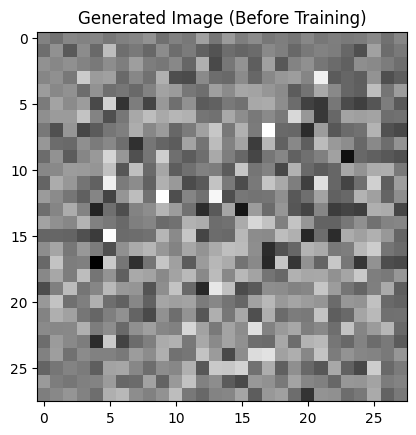

In [6]:
# Use the generator model which is not trained yet to create an image
generator = make_generator_model()

# Generate random noise
noise = tf.random.normal([1, 100])

# Generate an image from the noise
generated_image = generator(noise, training=False)

# Visualize the generated image
import matplotlib.pyplot as plt

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("Generated Image (Before Training)")
plt.show()


In [ ]:
# what is this image?


- The above image represents noise. The generator model has not been trained yet, so it does not know how to generate realistic handwritten digits.
- It outputs a 28x28 image based on the random noise input. Since no meaningful training has occurred, the output appears as random patterns.
- On another hand, this step is crucial to ensure that the generator model's architecture is correctly set up and can accept a noise input to produce an output image of the correct shape (28x28, grayscale).
- The next step to generate meaningful images, is to train the generator along with a descriminator in a GAN framework.

**c)**   Now, create discriminator  model using Keras. Like what we did above, apply this discriminative model on top of the above generate image and see the result. Maybe looking at the output does  not reveal enough information. Instead,  you can apply  a cross_entropy function to compare the
output with the real  one.

**d)** We need to create two loss loss functions.

•   Discriminator  loss: This method quantifies how well the discriminator is
able to distinguish real  images from fakes. It compares the discriminator's predictions on real  images  to an  array of 1s, and the discriminator's predictions on fake (generated)  images to an array of 0s.

•   Generator  loss: The generator's loss quantifies  how well  it was able to trick the discriminator. Intuitively,  if the generator is performing  well, the discriminator  will classify the fake images as real (or  1). Here,  we will compare the discriminators decisions on the generated images to an array of 1s.


In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Explicitly define the input layer
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))  # Input shape for MNIST images

    # Add subsequent layers
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model



In [10]:
# Applying discriminative model on the untrained image which was the output of generative model
discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00094201]], shape=(1, 1), dtype=float32)


- The above result represents the discriminator's confidence about whether the image is real or fake.
  - A value close to 0 means it thinks the image is fake.
  - A value close to 1 means it thinks the image is real.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

In [11]:
#d- Compute the loss
# Discriminator loss This method quantifies how well the discriminator is able to distinguish real images from fakes.
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    total_loss = real_loss + fake_loss
    return total_loss


In [12]:
#Generator loss The generator's loss quantifies how well it was able to trick the discriminator.
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fake images labeled as 1


In [13]:
#The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


**e)** Now,  is the time for  training the model.  It is recommended to take a checkpoint on model. The training loop begins with generator receiving a random seed as  input. That seed is  used to produce an image. The discriminator  is then used to classify real  images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for  each of these
models, and the gradients  are used to update the generator and discriminator.

There is a function provided for you to train the model  and  save the image.

You can call the train function with two elements train_dataset and number of epochs. The model takes a while to train but saving checkpoints  allows us  to get back to model whenever it is needed.  While the model  is loading,  pay attention to the changes in epochs and results.  After done with training, take a checkpoint and save the model. I recommend to download the model on your Google drive or a local machine. This helps not to re-train the model next time that you need to retrieve the model.

I also provided a code to save the steps of changes as  a gif file.

## Mounting google drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Module_6/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Defining model parameters

In [21]:
# Model parametrs

# Define training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Use a fixed random seed for generating GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Defining training step

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


## Defining training loop

In [23]:
#The training loop begins with generator receiving a random seed as input. That seed is used to produce an image.
#The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
#The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Generate and save images during training
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

    # Generate and save final images after training
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)



## Defining function to save every image generated at each epoch

In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Save the image at each epoch
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Computer Vision/Module_6/image_at_epoch_{epoch:04d}.png')
    plt.show()


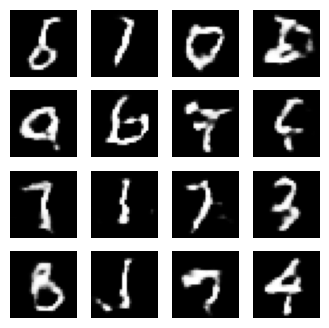

In [27]:
#Call the function in proper way
# Train the GAN
train(train_dataset, EPOCHS)

## Restore from Checkpoint (Optional)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Saving generated image as a GIFT

In [29]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Module_6/GAN_digit.gif'

# Using imageio.v2 to prevent deprecation warnings
import imageio.v2 as imageio

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Module_6/image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## Displaying new GIFT

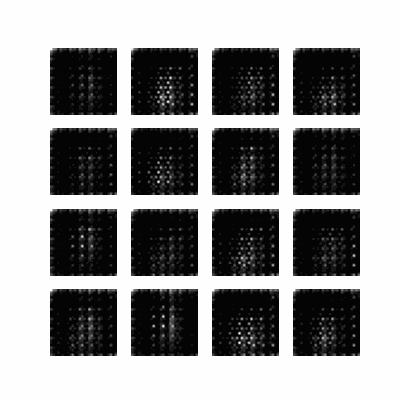

In [30]:
from IPython.display import Image, display as ipy_display

# Display the generated GIF
gif_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Module_6/GAN_digit.gif'

# Ensure the GIF exists
if os.path.exists(gif_path):
    ipy_display(Image(filename=gif_path))
else:
    print("GIF file not found at:", gif_path)


In [ ]:
# what is your understanding from this GIF file?



During the training loop, the `generate_and_save_images `function is called at the end of each epoch. This function takes the generator's output (based on a fixed random seed) and saves the generated images as .png files. These images show how the generator improves over time in creating realistic handwritten digits.

Once training is complete, all the .png images saved during the epochs are compiled into a GIF using the imageio library. This GIF provides a visual representation of the generator's progress during training.

At the beginning of training, the generated images will look like random noise.
As training progresses, the images will gradually become more recognizable as handwritten digits as the generator learns to produce realistic outputs.

# **Part 2- GAN and  Pokemon!**

The next  example is  inspired from  Intro to Generative Adversarial Networks (GANs) | Towards Data Science and d2l.ai. The goal of this model is to create the characters of pokemon using a GAN model.  The dataset that  we use is from d2l package (d2l ·  PyPI).

**a)** Read the pokemon dataset. It contains 40597 images from 71 clsses. Write a function to normalize the images  by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.

**b)** As we discussed earlier, it is always good to visualize our data to get better insights. Run the provided code to see the images.

In [31]:
#Installing d2l package
!pip install d2l==1.0.0-alpha1.post0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling i

## Importing necessary libraries

In [32]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [33]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [34]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
# Define a normalization function

def transform_func(x):
    # Normalize pixel values to [-1, 1] range
    x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0, 1]
    x = (x - 0.5) / 0.5  # Normalize to [-1, 1] using Gaussian normalization
    return x


In [35]:
# Apply the transformation function
data_iter = pokemon.map(
    lambda x, y: (transform_func(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# Cache, shuffle, and prefetch the dataset for efficient training
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


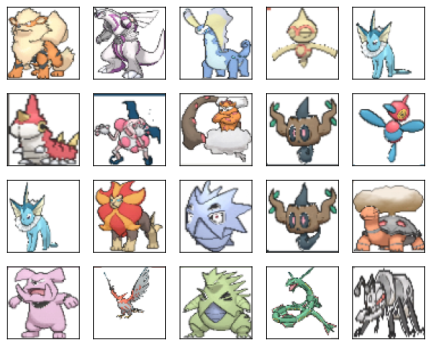

In [42]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))

# Take the first batch of images
for x, y in data_iter.take(1):
    imgs = x[:20, :, :, :]  # Get the first 20 images
    imgs = (imgs + 1) / 2  # Rescale to [0, 1] for visualization
    d2l.show_images(imgs, num_rows=4, num_cols=5)  # Visualize in a grid


**c)**   We start  with generator model  in which the noise is converted to an RGB  image.  This is a special  case that  uses convolutional  layer to create this  model. You can read more about  this type of model  here  (Barua,  et.al  2019). Import a signal in the form of zeros  into  the model. This input  has stride of 2,  in a 16x16 image and for three channels which means  x = tf.zeros((2, 16,3))

**d)**   Now, call the G_block package and use 20 as the number of  layers (input  of the class). To see the dimension of the output, you can use:  g_blk(x).shape

**e)** Now is the time to create discriminator. The block is already provided for you. Import a signal in the form of zeros into  the model. This input has stride of 2,  in a 16x16 image and for three channels which means  x = tf.zeros((2, 16, 16, 3))

Now, call the D_block package and use 20 as the number of  layers (input  of the class). To see the dimension of the output, you can use:  d_blk(x).shape

**f)**   The training function is already provided. Explain your  understanding about the training block.

Call the train function with appropriate values.  What is your understanding from the graph?




## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [43]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
# Explain your understanding of the G_block here.


The Generator block is designed to perform upsampling operations to increase the spatial resolution of the input tensor (image or feature map). This is achieved by using transpose convolution layers. The main goal is to progressively scale up the size of the latent representative (noise vector) to create a high-resolution image.

The key components of the G block are:

1. Conv2DTranspose layer. This layer performs a transpose convolution, which is also called: Deconvolution, which increases the spatial dimension of the input tensor.
  - `out_channels`, determines the depth of the output feature map.
  - The kernel size and strides, dictate the extent of upsampling and the receptive field.

2. Batch normalization. This is applied to normalize the output of the convolutional layer, helping to stabilize the training process and improve convergence. It standardizes the intermediate values within each layer and reduces internal covariate shift.

3. ReLu Activation. The rectified linear Unit activation function introduces non-linearity to the model and allows it to learn complex mappings.

The below output is an upscaled tensor. The height and width are doubled due to the transpose convolution operation, and the depth (number of channels) is determined by the `out_channels` parameter.

In [44]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [45]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [46]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

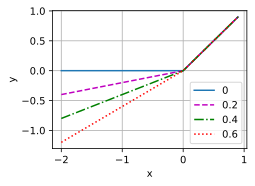

In [47]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

In [48]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
# Explain your understanding of D_block here.


The Discriminator block is a modular component designed to progressively downsample and extract hierarchical features from input images.

It does the following tasks:

1. Extracts features using convolution.
2. Normalizes the output for stability.
3. Applies a non-linear activation to learn complex patterns.

Key components:

1. Conv2D layer:

  - out_channels: Number of filters (defines the depth of the output feature map).
  - kernel_size: Size of the convolution kernel (filter).
  - strides: Step size of the convolution operation.
  - padding: Controls the spatial dimensions of the output. "same" ensures the output has the same spatial dimensions as the input.
  - use_bias=False: Disables bias terms since batch normalization is used.

2. BatchNormalization layer:

  - It normalizes the activations of the convolutional layer for faster convergence and stability. This prevents the discriminator from becoming biased toward high or low activations.

3. LeakyReLu:

- This is a rectified linear unit activation function that outputs zero for all negative inputs, which can stop the learning process. This function allows a small, non-zero gradient for negative inputs, ensuring the network can learn even for negative input values.

In [49]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [50]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [51]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training




In [56]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM
    )

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    # Corrected optimizer_hp
    optimizer_hp = {"learning_rate": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(
        xlabel="epoch",
        ylabel="loss",
        xlim=[1, num_epochs],
        nrows=2,
        figsize=(5, 5),
        legend=["discriminator", "generator"],
    )
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1, shape=(batch_size, 1, 1, latent_dim))
            metric.add(
                d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                batch_size,
            )

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat(
            [tf.concat([fake_x[i * 7 + j] for j in range(7)], axis=1) for i in range(len(fake_x) // 7)], axis=0
        )
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(
        f"loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, "
        f"{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}"
    )


In [ ]:
# Explain your understanding from this model here?


The goal of this trainin process is:

1. By applying the G_block, to learn how to generate realistic images from random noise to fool the discriminator.
2. With the usage of the D_block, to learn how to distinguish between real and fake images.

The training alternates between updating the generator and the discriminator

3. By updating  the discriminator. It minimizes the loss for distinguishing real images from fake images by the generator.
4. And the updating the generator. It minimizes the loss for fooling the discriminator into classifying generated images as real.

5. The Binary crossentropy loss is used for the discriminator, to measure its ability to correctly classify real vs fake images.
6. As for the generator, this measures its ability to fool the discriminator.

7. Adam optomizer is used for both the generator and discriminator. Where the learning rate, controls the step size for parameter updates, and the beta values are Adam optimizer's momentum parameters.

During the training loop, there are different key processes:

8. Random noise. The generator takes random noise as input to produce images.
9. A batch of real images is fed to the discriminator. Then, random noise is fed to the generator to produce fake images, which are then passed to the discriminator.

10. The accumulation of metrics gets tracked: discriminator loss, generator loss, and different number of examples, in this case: pokemon images are processed in each step.
11. As we can see in the below example, real-time visualization of the pokemon generated images and loss curves helps to monitor the training progress.

12. Lastly, Nash equilibrium aims the generator to improve until the discriminator is unable to distinguish real from fake images. When reaching this point, the generator has successfully learned to produce realistic images.

loss_D 0.607, loss_G 1.032, 1173.8 examples/sec on /GPU:0


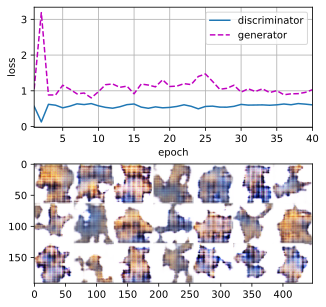

In [57]:
#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.
# Training parameters
# Define training parameters
latent_dim = 100          # Dimension of the latent space
lr = 0.0002               # Learning rate for the Adam optimizer
num_epochs = 40           # Number of epochs

# Call the train function
train(
    net_D=net_D,          # Discriminator network
    net_G=net_G,          # Generator network
    data_iter=data_iter,  # Training data iterator
    num_epochs=num_epochs,  # Number of training epochs
    lr=lr,                # Learning rate
    latent_dim=latent_dim # Latent dimension
)



In [ ]:
# what is your understanding from this learning curve?


- The blue line, which represents the discriminator loss starts relatively high and stabilizes over time. A stability in the loss suggest that the discriminator is neither overpowered nor underperforming. A lower discriminator loss indicates it effectively distinguishes real and fake images.

- The purple dashed line, which stands for the generator loss, fluctuates but later gets stabilized after few epochs. A moderate generator loss suggests that the generator is learning to produce more realistic images over time.

- We can see that at epoch 10, the loss curves reache a stable state. The generator and discriminator seems in balance, where the generator is producing realistic images, and the discriminator can perfectly distinguishing them.

- From the generated pokemon images, we can see that the generator initiallt produces random patterns but progressively learns to generate structure and visually coherent content.